In [13]:
import tensorflow as tf
import os

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Граф вычислений

In [15]:
import tensorflow as tf

a = tf.add(1, 2,)
b = tf.multiply(a, 3)
c = tf.add(4, 5,)
d = tf.multiply(c, 6,)
e = tf.multiply(4, 5,)
f = tf.div(c, 6,)
g = tf.add(b, d)
h = tf.multiply(g, f)

with tf.Session() as sess:
    print(sess.run(h))

63


# Линеная регрессия

## Тестовые данные

Подготовим два примера: 
1. Искуссственные данные
2. Реальный пример

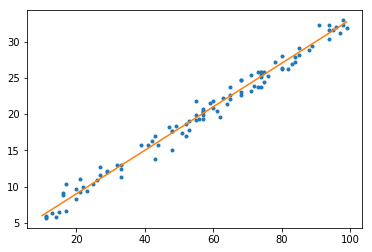

In [16]:
import numpy as np
X = np.random.randint(10,100,100)
theta = 0.3 
b = 3
y = X * theta + b  +  np.random.randn(100)

plt.plot(X,y, '.')
plt.plot(np.arange(10,100), np.arange(10,100) * theta + b)
artificial = {'X':X, 'y':y }

In [17]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]


## Формула

$\mathbf{y}=\mathbf{X} \mathbf{\theta} + \mathbf{\epsilon}$

$\mathbf{y}=\begin{vmatrix}
y_1\\
y_2\\
\vdots\\
y_n
\end{vmatrix}$
$\mathbf{X} = \begin{vmatrix}
1 \ x_{11} \ x_{12} \ \cdots \ x_{1p} \\
1 \ x_{21} \ x_{22} \ \cdots \ x_{2p} \\
\vdots \ \vdots \ \vdots \ \ddots \ \vdots \\
1 \ x_{n1} \ x_{n2} \ \cdots \ x_{np} \\
\end{vmatrix}$
$\mathbf{\theta} = \begin{vmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\vdots \\
\theta_p
\end{vmatrix}$
$\mathbf{\epsilon}=\begin{vmatrix}
\epsilon_1\\
\epsilon_2\\
\vdots\\
\epsilon_n\\
\end{vmatrix}$


Метод наименьших квадратов

$\mathbf{\theta = (X^T X)^{-1} X^T y}$


## Прямое вычисление

In [18]:
X_plus_bias = np.c_[np.ones((100, 1)), artificial['X']]

X = tf.constant(X_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(artificial['y'].reshape(-1,1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

b, theta =theta_value
print ('b = ', b[0], '; theta = ', theta[0] )

b =  3.0847745 ; theta =  0.29793346


In [19]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
print('b = ', theta_value[0,0], 'theta =', theta_value[1:,0])

b =  -37.18518 theta = [ 4.3633747e-01  9.3952334e-03 -1.0711310e-01  6.4479220e-01
 -4.0338000e-06 -3.7813708e-03 -4.2348403e-01 -4.3721911e-01]


## Метод градиентного спуска (производная вычислена вручную)

Масштабирование 

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

Спуск

In [21]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
print('b = ', best_theta[0,0], 'theta =', best_theta[1:,0])

Epoch 0 MSE = 2.7544262
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727805
Epoch 300 MSE = 0.5585007
Epoch 400 MSE = 0.54907
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.53737885
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.5312425
Epoch 900 MSE = 0.5293705
b =  2.0685523 theta = [ 7.74078071e-01  1.31192386e-01 -1.17845066e-01  1.64778143e-01
  7.44081801e-04 -3.91945131e-02 -8.61356556e-01 -8.23479712e-01]


## autodiff

In [22]:
tf.reset_default_graph()
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")


#Градиент вычисляется автоматически
gradients = tf.gradients(mse, [theta])[0]

training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print('b = ', best_theta[0,0], 'theta =', best_theta[1:,0])



Epoch 0 MSE = 2.7544262
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727805
Epoch 300 MSE = 0.5585007
Epoch 400 MSE = 0.54907
Epoch 500 MSE = 0.54228795
Epoch 600 MSE = 0.5373789
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.5312425
Epoch 900 MSE = 0.5293704
b =  2.0685525 theta = [ 7.74078071e-01  1.31192386e-01 -1.17845066e-01  1.64778143e-01
  7.44078017e-04 -3.91945094e-02 -8.61356676e-01 -8.23479772e-01]


## Tesnorflow GradientDescentOptimizer


In [23]:
n_epochs = 1000
learning_rate = 0.01
tf.reset_default_graph()

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
print('b = ', best_theta[0,0], 'theta =', best_theta[1:,0])


Epoch 0 MSE = 2.7544262
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727805
Epoch 300 MSE = 0.5585007
Epoch 400 MSE = 0.54907
Epoch 500 MSE = 0.54228795
Epoch 600 MSE = 0.5373789
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.5312425
Epoch 900 MSE = 0.5293704
b =  2.0685525 theta = [ 7.74078071e-01  1.31192386e-01 -1.17845066e-01  1.64778143e-01
  7.44078017e-04 -3.91945094e-02 -8.61356676e-01 -8.23479772e-01]


##  Mini-batch GradientDescentOptimizer

В рельаной жизни, когда для обучения иногда требуется использовать базу из миллионов изображений, невозможно подать все данные на вход алгоритму оптимизации. 

Для решения этой проблемы, исходный данные разбиваются на части ("mini-batch"), а алгоритм минимизации получается средним между стохастический градиентный спуск и методом наискорейшего спуска. 

In [34]:
n_epochs = 1000
learning_rate = 0.01
tf.reset_default_graph()



X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch



with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

print('b = ', best_theta[0,0], 'theta =', best_theta[1:,0])


b =  2.070016 theta = [ 0.8204561   0.1173173  -0.22739051  0.3113402   0.00353193 -0.01126994
 -0.91643935 -0.8795008 ]


# Tensorboard

TensorBoard – это набор веб-приложений для проверки и понимания того, как работают ваши графы в TensorFlow на самом деле. В настоящее время TensorBoard поддерживает пять типов визуализаций: скаляры, изображения, аудио, гистограммы и графы. Вычисления, которые вы далее будете реализовывать при помощи TensorFlow, т.к. например deep learning обучение нейронных сетей, могут быть довольно сложными и запутанными. TensorBoard упростит их понимание, отладку и оптимизацию.

## Создадим простой граф

In [24]:
import tensorflow as tf

a = tf.add(1, 2,)
b = tf.multiply(a, 3)
c = tf.add(4, 5,)
d = tf.multiply(c, 6,)
e = tf.multiply(4, 5,)
f = tf.div(c, 6,)
g = tf.add(b, d)
h = tf.multiply(g, f)

with tf.Session() as sess:
    print(sess.run(h))

63


Для того, чтобы увидеть наш граф в tensorboard, необходимо добавить запись в файл

In [25]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter(os.path.expanduser('~/model/demo1/'), sess.graph)
    print(sess.run(h))
    writer.close()

63


Запустите tensorboard. Для этого на рабочем столе нажмите на пиктограмму Tensorboard demo1

## Оценка сходимости
Для анализа минимизации можно вывести знаечние любой переменной в файл для дальнейшей ее визуализации в tensrboard.

In [32]:
n_epochs = 1000
learning_rate = 0.01
tf.reset_default_graph()



X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()



mse_summary = tf.summary.scalar('MSE', mse)


n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))
file_writer = tf.summary.FileWriter(os.path.expanduser('~/model/demo2/'), tf.get_default_graph())

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch



with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()


writer.close()
print('b = ', best_theta[0,0], 'theta =', best_theta[1:,0])


b =  2.070016 theta = [ 0.8204561   0.1173173  -0.22739051  0.3113402   0.00353193 -0.01126994
 -0.91643935 -0.8795008 ]


Запустите tensorboard. Для этого на рабочем столе нажмите на пиктограмму Tensorboard demo2